In [1]:
import numpy as np 

import matplotlib.pyplot as plt 
from qiskit.quantum_info import SparsePauliOp, Statevector, \
                                Operator, process_fidelity
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, \
                    ClassicalRegister 
from scipy.linalg import expm

# Simulación cuántica

La simulación de sistemas físicos es una tarea computacional importante con muchas aplicaciones. El núcleo de la simulación de sistemás físicos es resolver las ecuaciones diferenciales que capturan las leyes que gobiernan la dinámica del sistema. En el caso de los sistemas cuánticos, estos son gobernados por la ecuación de Schrödinger
$$ i\frac{d}{dt}|\psi\rangle = H |\psi\rangle, $$
donde $H$ es el Hamiltoniano del sistema. Resolver esta ecuación con medios clásicos es posible. Sin embargo, esto es generalmente ineficiente porque la dimensión del espacio de estados crece exponencial con el número de qubits, es decir, tenemos una cantidad exponencial de ecuaciones diferenciales por resolver.

Los computadores cuánticos, los cuales naturalmente evolucionan de acuerdo a la ecuación de Schrödinger, prometen simular eficientemente sistemas cuánticos intratables clasicamente. El propio Richard Feymann, premio nobel en física, proyectaba esta aplicación:

"Nature isn't classical, dammit, and if you want to make a simulation of nature, you'd better make it quantum mechanical, and by golly it's a wonderful problem, because it doesn't look so easy." 

En este taller veremos como simular la conductividad de electrones en un material sólido a través del modelo "tight-binding" tanto clasicamente como cuánticamente. Particularmente, el algoritmo de simulación cuántica que utilizaremos será la fórmula de Trotter.

## Modelo "tight-binding" 

El modelo tight-binding describre el transporte de electrones a través de un materia sólido. En este cada átomo es tratado como un qubit, mientras que los electrones ocupan estos qubits y pueden saltar entre ellos. Por ejemplo, consideremos 7 átomos con 1 electrón de conducción. El estado
$$ |1\rangle_7|0\rangle_6|0\rangle_5|0\rangle_4|0\rangle_3|0\rangle_2|0\rangle_1|0\rangle_0,  $$
representa un electrón en el átomo 7. El Hamiltoniano que describe este modelo es,
$$ H = \sum_{j} \epsilon_j Z_j + J \sum_{j}( X_jX_{j+1} + Y_jY_{j+1} ).$$
El primer término describe la energía de cada átomo, mientras que el segundo describe la interacción entre átomos vecinos y el salto de los electrones.

<img src="./img/ecc24_trotter_1.jpg" 
     align="left" 
     width="500" />

### Simulación clásica

La solución de la ecuación de Schrödinger cuando el Hamiltoniano es independiente del tiempo es dada por
$$ | \psi(t)\rangle = U(t)| \psi(0)\rangle, $$
donde $$U(t)=e^{-iHt},$$ es el operador de evolución. [Notemos que esta exponencial actúa sobre el espectro de $H$ y no sobre cada uno de los elementos de $H$](https://en.wikipedia.org/wiki/Matrix_exponential). La simulación clásica del modelo tight binding consiste en calcular numericamente el operador de evolución $U(t)$. Por simplicidad supondremos que $\epsilon_j=0$ para todo átomo y J = 1.

$$ H = \sum_{j}( X_jX_{j+1} + Y_jY_{j+1} ).$$

In [2]:
# Primero definimos los operadores de Pauli
I = SparsePauliOp.from_list( [ ( 'I', 1) ] )
X = SparsePauliOp.from_list( [ ( 'X', 1) ] )
Y = SparsePauliOp.from_list( [ ( 'Y', 1) ] )
Z = SparsePauliOp.from_list( [ ( 'Z', 1) ] )

In [3]:
#Definimos el número de qubits
num_qubits = 7

In [4]:
# Construimos el Hamiltoniano
def H_tb():
        op_list = []
        for k in range(num_qubits-1):
                XX = num_qubits * ['I']
                XX[ k ] = 'X'
                XX[ k+1 ] = 'X'
                XX = "".join(XX)  
                
                YY = num_qubits * ['I']
                YY[ k ] = 'Y'
                YY[ k+1 ] = 'Y'
                YY = "".join(YY)  
                
                op_list.append( (XX,1) )
                op_list.append( (YY,1) )
        H = SparsePauliOp.from_list( op_list )
        return H

In [5]:
# Imprimamos el Hamiltoniano
H_tb()

SparsePauliOp(['XXIIIII', 'YYIIIII', 'IXXIIII', 'IYYIIII', 'IIXXIII', 'IIYYIII', 'IIIXXII', 'IIIYYII', 'IIIIXXI', 'IIIIYYI', 'IIIIIXX', 'IIIIIYY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])

In [6]:
#  Operador de evolución 
def U_tb(t):
    H = H_tb().to_matrix()
    return expm( -1j*H*t )

In [7]:
# Imprimamos el operador de evolución
U_tb(0)

array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]])

Consideremos como estado inicial un electrón en el primer átomo de la izquierda, es decir
$$|\psi(0)\rangle = |1\rangle|0\rangle|0\rangle|0\rangle|0\rangle|0\rangle|0\rangle. $$

In [8]:
ket0  = Statevector([1,0])
ket1  = Statevector([0,1])
state_in = eval( 'ket1'+(num_qubits-1)*'^ket0' )
state_in

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.

Ahora calculamos la evolución hasta $t=3$ y graficamos la probabilida de que el electrón esté en cada átomo en función del tiempo.

In [9]:
times = np.linspace(0, 10,30) 
probs_out = np.array( [ np.abs( 
                U_tb(t) @ state_in.__array__() )**2 
                for t in times ] )

Text(0, 0.5, 'Tiempo')

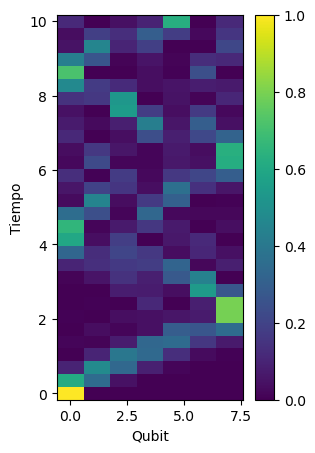

In [10]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh( np.linspace(0,num_qubits,num_qubits), 
                times,
                probs_out[:, 2**np.arange(num_qubits)[::-1] ] )
plt.colorbar()
plt.xlabel('Qubit')
plt.ylabel('Tiempo')

Vemos que el electrón parte en el átomo de más a la izquierda, pero luego salta a los átomos vecinos hasta llegar al de más a la derecha. Posteriormente el electrón es reflejado y vuelve al átomo de la izquierda.

### Simulación Cuántica

Podemos simular la dinámica de un sistema cuántico en un computador cuántico mediante la fórmula de Trotter. Esta esta dada por
$$ e^{A+B} = \lim_{m \rightarrow \infty} \left( e^{A/m} e^{B/m}  \right)^m, $$
donde $A$ y $B$ son operadores. Podemos pensar que esta es la versión cuántica de la relación clásica $e^{a+b}=e^a e^b$, con $a,b\in\mathbb{C}$. Consideremos el Hamiltoniano  $H=\sum_j H_j$ de $n$ qubits, con $H_j$ operadores que no involucran todos los qubits,
$$ H_{j} = X_jX_{j+1} + Y_jY_{j+1},$$

donde usaremos J=1. Además, su correspondiente operador de evolución es $U(t)= e^{ -it\sum_j H_j }$. La fórmula de Trotter nos permite approximar esta evolución hasta orden $m$ por
$$ U(t) \approx \left( \prod_{j} e^{-itH_j/m}  \right)^m .$$
Para el caso del modelo tight binding tenemos que
$$ H_{2j+1} = X_jX_{j+1}, \qquad H_{2j+2} = Y_jY_{j+1}, $$
de modo que el operador de evolución puede ser approximado mediante
$$ U(t) \approx \left(  e^{-itX_0X_{1}/m}e^{-itY_0Y_{1}/m}\cdots e^{-itX_{n-2}X_{n-1}/m}e^{-itY_{n-2}Y_{n-1}/m} \right)^m.$$
Así, necesitamos construir circuitos que implementes las puertas
$$ XX_j(t) = e^{ -itX_jX_{j+1} }, \qquad YY_j(t) = e^{ -itY_jY_{j+1} }. $$

Estas puertas pueden ser aplicadas utilizando la compuerta ZZ y transformaciones de esta.



In [11]:
# Definimos el parámetro t
t = Parameter('t')

Puerta ZZ:

![gaet_ZZ](img/gate_ZZ.png)

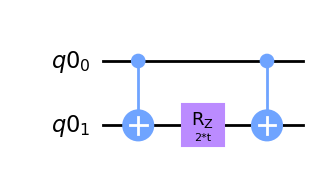

In [12]:
# Construimos el circuito ZZ(t)

ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

###EDITAR BAJO ESTA LINEA (agregar compuertas)
ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)
###NO EDITAR BAJO ESTA LINEA

# Convertimos nuestro circuito en una puerta 
ZZ = ZZ_qc.to_instruction()

ZZ_qc.draw('mpl')

Puerta XX:

![gaet_XX](img/gate_XX.png)

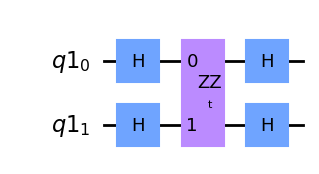

In [13]:
# Construimos la puerta XX(t) a partir de ZZ(t)
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

###EDITAR BAJO ESTA LINEA (agregar compuerta)
XX_qc.h([0,1])
###NO EDITAR BAJO ESTA LINEA

XX_qc.append(ZZ, [0,1])

###EDITAR BAJO ESTA LINEA (agregar compuerta)
XX_qc.h([0,1])
###NO EDITAR BAJO ESTA LINEA

# Convertimos nuestro circuito en una puerta 
XX = XX_qc.to_instruction()

XX_qc.draw('mpl')

PUERTA YY:

![gaet_YY](img/gate_YY.png)

HINT: Puertas .s() y .sgd()

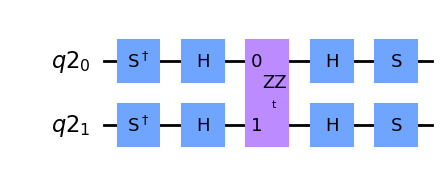

In [14]:
# Construimos la puerta YY(t) a partir de ZZ(t)
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

###EDITAR BAJO ESTA LINEA (agregar compuertas)
YY_qc.sdg([0,1])
YY_qc.h([0,1])
###NO EDITAR BAJO ESTA LINEA

YY_qc.append(ZZ, [0,1])

###EDITAR BAJO ESTA LINEA (agregar compuertas)
YY_qc.h([0,1])
YY_qc.s([0,1])
###NO EDITAR BAJO ESTA LINEA

# Convertir el circuito cuantico en una puerta
YY = YY_qc.to_instruction()

YY_qc.draw('mpl')

Ahora construimos el paso de Trotter
$$ U_{step}(t) = e^{-itX_0X_{1}/m}e^{-itY_0Y_{1}/m}\cdots e^{-itX_{n-2}X_{n-1}/m}e^{-itY_{n-2}Y_{n-1}/m} $$ 

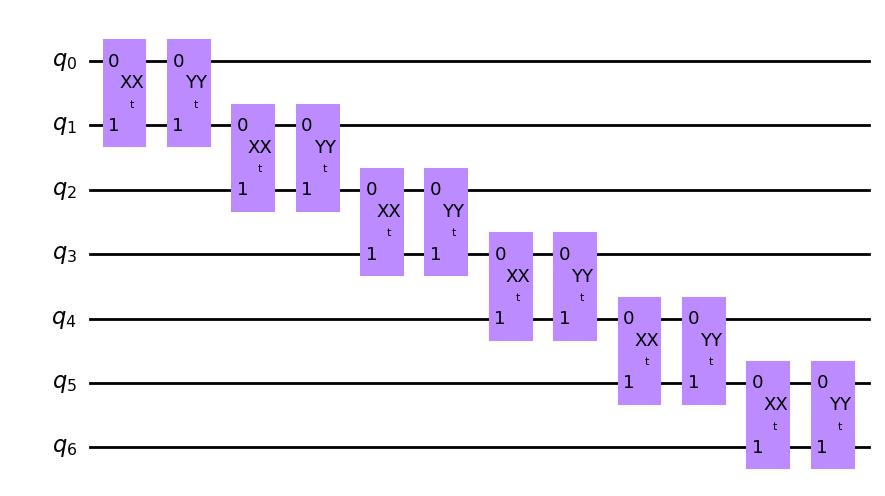

In [30]:
Trot_tb_qr = QuantumRegister(num_qubits, 'q')
Trot_tb_qc = QuantumCircuit(Trot_tb_qr, name='Trot')


for j in range(num_qubits-1):
    ###EDITAR BAJO ESTA LINEA
    ### HINT: .append(gate, [qubits])
    Trot_tb_qc.append(XX,[j,j+1])
    Trot_tb_qc.append(YY,[j,j+1])
###NO EDITAR BAJO ESTA LINEA

Trot_tb_gate = Trot_tb_qc.to_instruction()

Trot_tb_qc.draw('mpl')

Construimos la approximación de Trotter,
$$ U(t)\approx \left[ U_{step}(t) \right]^m $$

In [16]:

def U_trotterize(delta_t, trotter_steps):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    ###EDITAR BAJO ESTA LINEA (Crear el circuito trotterizado con varios pasos de trotter )
    for step in range(trotter_steps):
        qc.append( Trot_tb_gate, list(range(num_qubits)) )
    ###NO EDITAR BAJO ESTA LINEA
    
    qc = qc.bind_parameters({t: delta_t })
    
    return qc

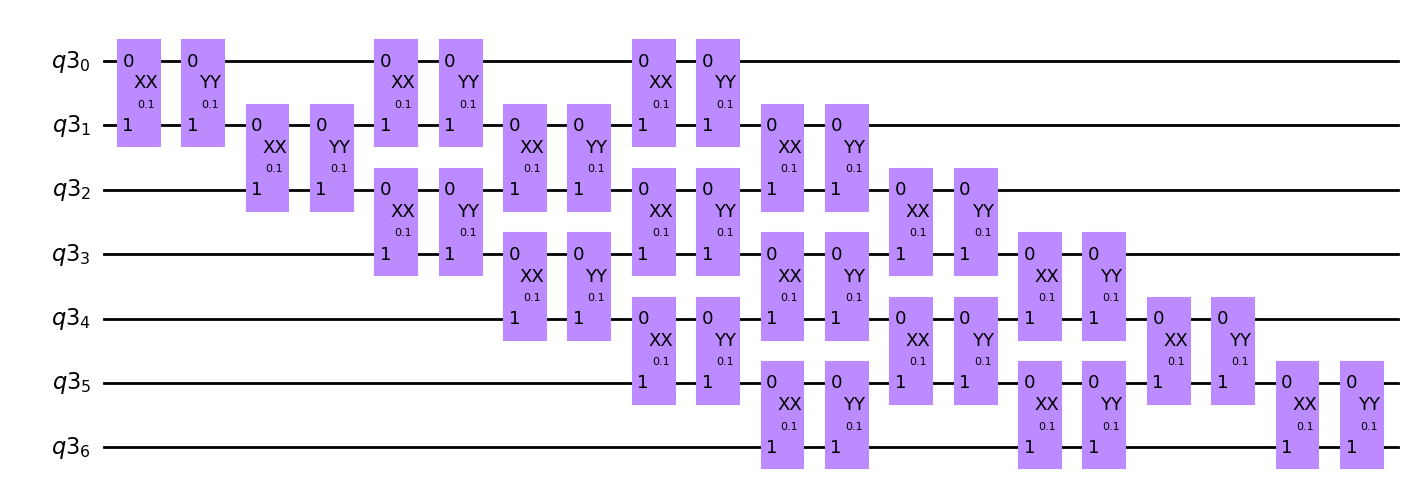

In [17]:
qc = U_trotterize( 0.1, 3 )
qc.decompose(reps=1).draw('mpl') 

Simulamos la dinámica hasta $t=3$.

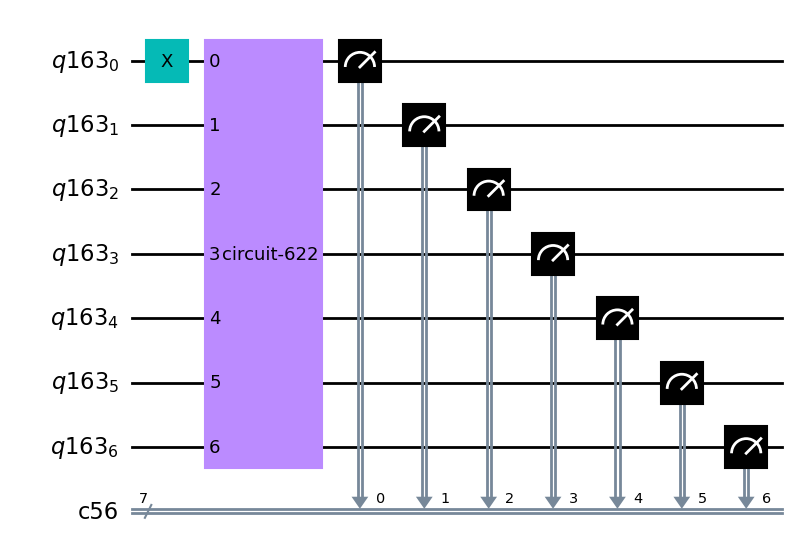

In [31]:
delta_t=0.15 # NO EDITAR dt = t/m
time_steps=np.arange(1,20,1) # NO EDITAR

circuits=[]

for n_steps in time_steps:
    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr,cr)

    ###EDITAR BAJO ESTA LINEA (iniciar electron, agregar circuito trotter, medir)
    qc.x(0)

    qc.append( U_trotterize(delta_t, n_steps), 
                [i for i in range(num_qubits)])

    qc.measure( qr, cr )
    ###NO EDITAR BAJO ESTA LINEA
    
    circuits.append(qc)

qc.draw('mpl')

In [19]:
from qiskit.primitives import Sampler 
# Usar qiskit primitives statevector simulator

sampler = Sampler()

probability_density=[]
for circ in circuits:
    
    job = sampler.run(circ)

    # Colectar los resultados del trabajo (job.)
    result = job.result()
    probs = result.quasi_dists[0]
    probability_density.append([ probs.get(2**key,0) 
                                for key in range(num_qubits) ])

    
probability_density=np.array(probability_density)

Graficamos las probabilidades de que el electrón este en cada átomo.

Text(0, 0.5, 'Time')

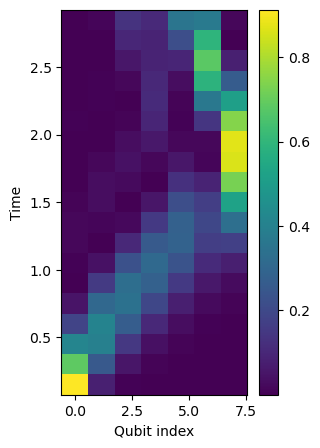

In [20]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh( np.linspace(0,num_qubits,num_qubits), 
                time_steps*delta_t ,
                probability_density)
plt.colorbar()
plt.xlabel('Qubit index')
plt.ylabel('Time')

Vemos que una dinámica similar al caso clásico, es decir, un transporte del electrón de izquierda a derecha, y despues de derecha a izquierda. Sin embargo, como la fórmula de Trotter solo nos permite approximar el operador de evolución, la simulación cuántica es levemente distinta a la clásica. ¿De cuánto es este error? Depende del número de pasos de Trotter, lo cual se puede ver en el siguiente gráfico.

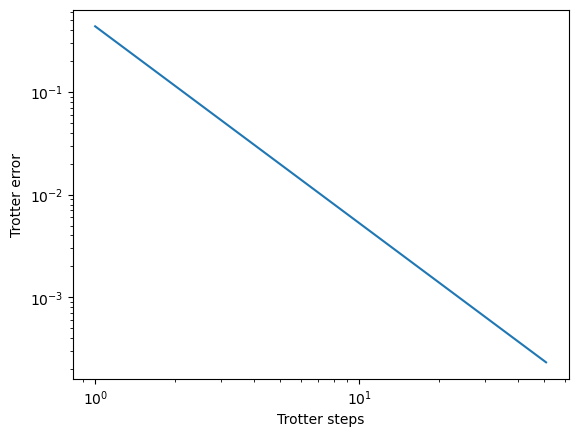

In [29]:
t_target = 0.5

U_target = U_tb(t_target)

steps=np.arange(1,101,50)  ## NO EDITAR ESTA LINEA

fidelities=[]
for n in steps:
    U_trotter = Operator( 
                U_trotterize(t_target/n, trotter_steps=n) )
    fidelity = process_fidelity(U_trotter, target=U_target)
    fidelities.append(fidelity)

plt.figure(facecolor='white') 
plt.loglog(steps, 1-np.array(fidelities)) 
plt.ylabel('Trotter error') 
plt.xlabel('Trotter steps') 
plt.show()

## Localización de Anderson 
Ahora simularemos cuánticamente el modelo tight binding en un contexto más interesante. La propagación de un electrón en una red cristalina se ve afectado por la introducción de desorden en la energías de cada átomo $\epsilon_j$, lo que lleva a un fenomeno conocido como localización de Anderson. La inhomogeneidad de la red cristalina causa dispersión y produce una interferencia cuántica que tiende a inhibir la propagación de la partícula, localizandola en una región pequeña de la red cristalina.

$$ H = \sum_{j} \epsilon_j Z_j + X_jX_{j+1} + Y_jY_{j+1}.$$

<img src="./img/ecc24_trotter_2.jpg" 
     align="left" 
     width="500" />

Phillip Anderson propuso por primera vez en 1958 que la dispersión debida al desorden puede detener completamente el transporte. Antes del descubrimiento de Anderson, los científicos modelaban el desorden cristalino como perturbaciones que dispersaban a los electrones de manera aleatoria, tratando a los electrones como partículas puntuales. Esta lógica, llevo a la descripción del transporte en estos sistemas como un movimiento browniano, en el que subyace la ley de Ohm. Sin embargo, Anderson revisitó el efecto del desorden en la evolución de la estado de un electrón, a su vez en un cristal periódico . Anderson analizó el problema en el régimen cuántico, así tomando en cuenta la naturaleza ondulatoria del electrón, y encontró que el movimiento difusivo clásico del electrón se pierde ya que la distribución de probabilidad del electrón se localiza exponencialmente. Por lo tanto, cuando un electrón está inicialmente ubicado en un átomo, su estado no podrá expandirse con el tiempo para cubrir todo el cristal, sino que más bien permanecerá localizado alrededor de su posición inicial. Así, el material dejará de conducir cargas eléctricas, y eventualmente se comportará como un aislante. Este fenómeno de localización es una consecuencia directa de los diferentes caminos de interferencia que surgen de las múltiples dispersiones del electrón con los defectos de la red cristalina.

Podemos inducir localización de Anderson en este sistema cambiando $\epsilon_j$ al crear un Aubry-Andre quasicristal que modela la transicion metal-aislante. Tenemos que
$$ \epsilon_i=W \rm{cos}(2\pi\beta i) ,$$
donde $W$ es el tamaño del desorden y $\beta$ determina la periodicidad del desorden en el cristal.

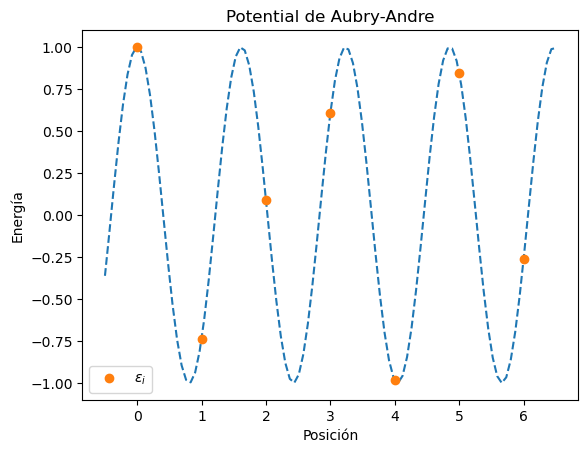

In [22]:
beta=(np.sqrt(5)-1)/2 # NO EDITAR
AA_patern=np.cos(2*np.pi*beta*np.arange(num_qubits)) # NO EDITAR

plt.plot(np.linspace(-0.5,6.5,101), 
        np.cos(2*np.pi*beta*np.linspace(-0.5,6.5,101)), '--')
plt.plot(np.arange(num_qubits), AA_patern, 'o', label=r'$\epsilon_i$')
plt.xlabel('Posición')
plt.ylabel('Energía')
plt.legend()
plt.title('Potential de Aubry-Andre')
plt.show()

Ahora nuestro paso de Trotter incluira los términos $\{\epsilon_j Z_j \}$, los cuales supusimos nulos en la primera parte del taller, es decir
$$ U_{step}(t) = \left( e^{-itX_0X_{1}/m}e^{-itY_0Y_{1}/m}\cdots e^{-itX_{n-2}X_{n-1}/m}e^{-itY_{n-2}Y_{n-1}/m} \right) \left(e^{-it\epsilon_0Z_0/m}\cdots e^{-it\epsilon_{n-1}Z_{n-1}/m}\right). $$ 


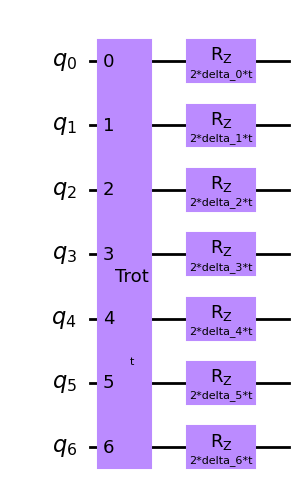

In [23]:
Trot_qr_disorder = QuantumRegister(num_qubits, 'q')
Trot_qc_disorder = QuantumCircuit(Trot_qr_disorder, name='Trot disorder')

Trot_qc_disorder.append( Trot_tb_gate, range(num_qubits) )
deltas=[ Parameter('delta_{:d}'.format(idx)) 
            for idx in range(num_qubits)]

###EDITAR BAJO ESTA LINEA (agregar desorden en cada qubit)
### Hint: autointeracción .rz()
for j in range( num_qubits) :
    Trot_qc_disorder.rz( 2*deltas[j]*t, j )
###NO EDITAR BAJO ESTA LINEA
    
# Convertir el circuito en una puerta
Trot_disorder_gate = Trot_qc_disorder.to_instruction()

Trot_qc_disorder.draw('mpl')

Simulamos nuevamente la dinámica hasta $t=3$.

In [33]:
delta_t=0.15
time_steps=np.arange(1,20,1)

W=2 # NO EDITAR

disorders=W*AA_patern # NO EDITAR

disorder_circuits=[]

for n_steps in time_steps:

    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr, cr)

    qc.x(0)
    
    for _ in range(n_steps):
        qc.append(Trot_disorder_gate, [i for i in range(num_qubits)])

    qc = qc.bind_parameters({t: delta_t})
    qc = qc.bind_parameters({deltas[idx]: disorders[idx] for idx in range(num_qubits)})

    qc.measure( qr, cr )

    disorder_circuits.append(qc)

Graficamos la probabilidad de que el electrón este en cada átomo.

In [25]:
probability_density_localization=[]
for circ in disorder_circuits:
    job2 = sampler.run(circ)
    probs = job2.result().quasi_dists[0] 
    probability_density_localization.append([ probs.get(2**key,0) 
                                for key in range(num_qubits) ])
        
probability_density_localization=np.array(probability_density_localization)

Text(0, 0.5, 'Time')

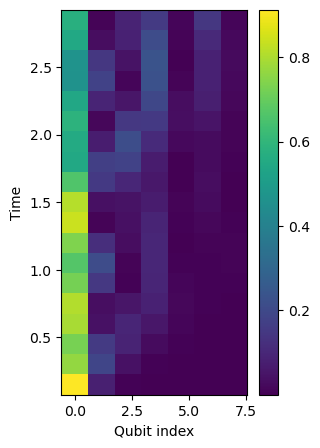

In [26]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh( np.linspace(0,num_qubits,num_qubits), 
                time_steps*delta_t ,
                probability_density_localization)
plt.colorbar()
plt.xlabel('Qubit index')
plt.ylabel('Time')

Vemos que la probabilidad de que el electrón este en el primer átomo de la izquiera es cercana a 1, mientras que la probabilidad de que este en los otros átomos es cercana a 0, es decir, el electrón esta localizado en el primer átomo!

Este taller fue construido por Luciano Pereira y Mauricio Casanova, inspirado en el [IBM quantum Challenge 2022 spring](https://github.com/qiskit-community/ibm-quantum-spring-challenge-2022).